# Hidden Markov Model (HMM) Classification of uci_HAR time sequences

### Dataset

uci_HAR dataset also includes the **time sequences** of Accelerometer & Gyroscope signals of each record before extracting the features.
They are available for the train and test data. Their descriptions are equivalent. 

- 'train/Inertial Signals/**total_acc_x_train.txt**': The acceleration signal from the smartphone accelerometer X axis in standard gravity units 'g'. Every row shows a 128 element vector. The same description applies for the 'total_acc_y_train.txt' and 'total_acc_z_train.txt' files for the Y and Z axis. 

- 'train/Inertial Signals/**body_acc_x_train.txt**': The body acceleration signal obtained by subtracting the gravity from the total acceleration. 

- 'train/Inertial Signals/**body_gyro_x_train.txt**': The angular velocity vector measured by the gyroscope for each window sample. The units are radians/second. 

- 'train/subject_train.txt': Each row identifies the subject who performed the activity for each window sample. Its range is from 1 to 30. 

### Algorithm
In this notebook, we use time sequences in train folder to train 6 HMM models (each HMM model for each of the activity labels),  then use these HMM models to classify each time sequence in test folder, and compare the results to the true test label to evaluate the accuracy.

For each observation in time sequences, there are 9 features:
- body_acc_x_train
- body_acc_y_train
- body_acc_z_train
- total_acc_x_train
- total_acc_y_train
- total_acc_z_train
- body_gyro_x_train
- body_gyro_y_train
- body_gyro_z_train

However, the HMM package that we use (hmmlearn) doesn't support multidimensional observations (Multivariate HMM).

Thus before training the HMM models, we need to use K-Means to quantize all the observations of all time sequences in train folder in to K clusters. And then we use the quantized time sequences to train HMM models with multinomial (discrete) emissions.

For the same reason, before testing on time sequences in test folder, we use the trained K-Means to quantize all the observations, and then we use the trained HMM models to classify each quantized time sequences.

#### Algorithm Pipeline
The whole algorithm pipeline is as the following graph:
> 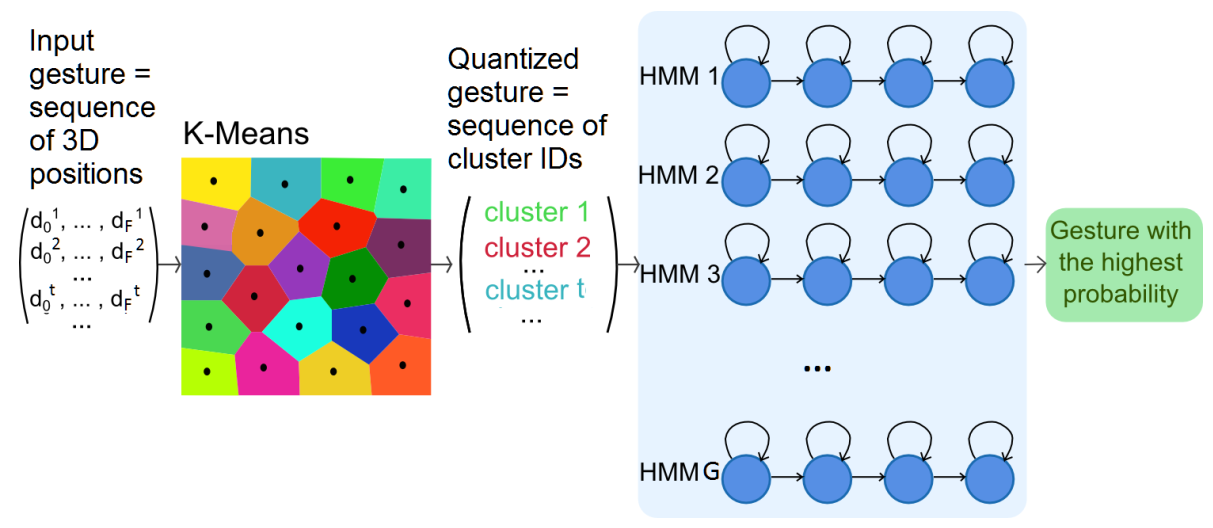
> Reference:
*Eva Coupeté · Fabien Moutarde · Sotiris Manitsaris -- "Multi-users online recognition of technical gestures for natural Human-Robot Collaboration in manufacturing"*

### import the necessary packets

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from hmmlearn import hmm

import warnings
warnings.filterwarnings('ignore')

### Data loading and formatting

Load the data of time sequences of Accelerometer & Gyroscope signals, as well as the activity labels corresponding to each time sequence

In [2]:
y_train = pd.read_csv('train/y_train.txt', sep='\n', header=None, names=['Activity No.'])
y_test = pd.read_csv('test/y_test.txt', sep='\n', header=None, names=['Activity No.'])

body_acc_x_train = pd.read_csv('train/Inertial Signals/body_acc_x_train.txt', sep='\s+', header=None, index_col=False)
body_acc_y_train = pd.read_csv('train/Inertial Signals/body_acc_y_train.txt', sep='\s+', header=None, index_col=False)
body_acc_z_train = pd.read_csv('train/Inertial Signals/body_acc_z_train.txt', sep='\s+', header=None, index_col=False)
body_gyro_x_train = pd.read_csv('train/Inertial Signals/body_gyro_x_train.txt', sep='\s+', header=None, index_col=False)
body_gyro_y_train = pd.read_csv('train/Inertial Signals/body_gyro_y_train.txt', sep='\s+', header=None, index_col=False)
body_gyro_z_train = pd.read_csv('train/Inertial Signals/body_gyro_z_train.txt', sep='\s+', header=None, index_col=False)
total_acc_x_train = pd.read_csv('train/Inertial Signals/total_acc_x_train.txt', sep='\s+', header=None, index_col=False)
total_acc_y_train = pd.read_csv('train/Inertial Signals/total_acc_y_train.txt', sep='\s+', header=None, index_col=False)
total_acc_z_train = pd.read_csv('train/Inertial Signals/total_acc_z_train.txt', sep='\s+', header=None, index_col=False)

body_acc_x_test = pd.read_csv('test/Inertial Signals/body_acc_x_test.txt', sep='\s+', header=None, index_col=False)
body_acc_y_test = pd.read_csv('test/Inertial Signals/body_acc_y_test.txt', sep='\s+', header=None, index_col=False)
body_acc_z_test = pd.read_csv('test/Inertial Signals/body_acc_z_test.txt', sep='\s+', header=None, index_col=False)
body_gyro_x_test = pd.read_csv('test/Inertial Signals/body_gyro_x_test.txt', sep='\s+', header=None, index_col=False)
body_gyro_y_test = pd.read_csv('test/Inertial Signals/body_gyro_y_test.txt', sep='\s+', header=None, index_col=False)
body_gyro_z_test = pd.read_csv('test/Inertial Signals/body_gyro_z_test.txt', sep='\s+', header=None, index_col=False)
total_acc_x_test = pd.read_csv('test/Inertial Signals/total_acc_x_test.txt', sep='\s+', header=None, index_col=False)
total_acc_y_test = pd.read_csv('test/Inertial Signals/total_acc_y_test.txt', sep='\s+', header=None, index_col=False)
total_acc_z_test = pd.read_csv('test/Inertial Signals/total_acc_z_test.txt', sep='\s+', header=None, index_col=False)

Stack all 9 features for each observation of time sequences:

In [3]:
# Time sequences of training, each observation has 9 features stacked
sequence_train = np.dstack((body_acc_x_train, body_acc_y_train, body_acc_z_train, body_gyro_x_train, body_gyro_y_train, body_gyro_z_train, total_acc_x_train, total_acc_y_train, total_acc_z_train))
# Observations of all time sequences of training
sequence_train_obs = sequence_train.reshape(-1,9)

# Time sequences of testing, each observation has 9 features stacked
sequence_test = np.dstack((body_acc_x_test, body_acc_y_test, body_acc_z_test, body_gyro_x_test, body_gyro_y_test, body_gyro_z_test, total_acc_x_test, total_acc_y_test, total_acc_z_test))
# Observations of all time sequences of testing
sequence_test_obs = sequence_test.reshape(-1,9)

# True label of testing
y_test_true = y_test.values.flatten()

### Train HMM models, and then use them to classify time sequences of testing

As explained in the beginning of this notebook, we need to firstly run K-Means to quantize the time sequences, and then train HMM models for each activity label. And finally use the Multinomial (discrete) HMM models to classify quantized time sequences of testing.

In order to find the best accuracy, we have tried different K-Means cluster numbers and HMM state numbers.

In [7]:
kmeans_cluster = [15, 20, 25, 30, 35, 40]
hmm_state = [2, 5, 10, 15, 20, 25]

best_accuracy = 0

for cluster in kmeans_cluster:
    # Quantize time sequences of training into K clusters
    sequence_train_kmeans = KMeans(n_clusters=cluster).fit(sequence_train_obs)
    sequence_train_quantized = sequence_train_kmeans.labels_.reshape(-1,128)
    # Quantize time sequences of testing using K-Means trained on training data
    sequence_test_quantized = sequence_train_kmeans.predict(sequence_test_obs).reshape(-1,128)

    for state in hmm_state:
        hmm_model = []
        # Train a HMM model using quantized time sequences of training, train one HMM model for each activity
        for i in range(1,7):
            index_of_activity_i = y_train.index[y_train['Activity No.'] == i]
            hmm_model.append(hmm.MultinomialHMM(n_components=state).fit(sequence_train_quantized[index_of_activity_i]))
        
        # After training HMM models, use them to classify each quantized time sequence of testing
        scores = np.empty((0,6))
        for sequence in sequence_test_quantized:
            score = np.empty(6)
            for j in range(6):
                score[j] = hmm_model[j].score(sequence.reshape(1,128))
            scores = np.vstack((scores, score))
        
        # Get the prediction list
        y_test_predict = np.argmax(scores, axis=1) + 1
        # Compare the predictions with true labels, calculate accuracy
        accuracy = np.sum(y_test_predict == y_test_true) / len(y_test_true)
        print('KMeans cluster = %d, HMM state = %d,\t\tAccuracy = %.3f' % (cluster, state, accuracy))

        # Save the best accuracy information for further analysis
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_kmeans_cluster = cluster
            best_hmm_state = state
            best_y_test_predict = y_test_predict

KMeans cluster = 15, HMM state = 2,		Accuracy = 0.731
KMeans cluster = 15, HMM state = 5,		Accuracy = 0.727
KMeans cluster = 15, HMM state = 10,		Accuracy = 0.693
KMeans cluster = 15, HMM state = 15,		Accuracy = 0.700
KMeans cluster = 15, HMM state = 20,		Accuracy = 0.744
KMeans cluster = 15, HMM state = 25,		Accuracy = 0.737
KMeans cluster = 20, HMM state = 2,		Accuracy = 0.742
KMeans cluster = 20, HMM state = 5,		Accuracy = 0.743
KMeans cluster = 20, HMM state = 10,		Accuracy = 0.761
KMeans cluster = 20, HMM state = 15,		Accuracy = 0.749
KMeans cluster = 20, HMM state = 20,		Accuracy = 0.758
KMeans cluster = 20, HMM state = 25,		Accuracy = 0.770
KMeans cluster = 25, HMM state = 2,		Accuracy = 0.786
KMeans cluster = 25, HMM state = 5,		Accuracy = 0.749
KMeans cluster = 25, HMM state = 10,		Accuracy = 0.778
KMeans cluster = 25, HMM state = 15,		Accuracy = 0.719
KMeans cluster = 25, HMM state = 20,		Accuracy = 0.797
KMeans cluster = 25, HMM state = 25,		Accuracy = 0.789
KMeans cluster =

The best accuracy that we got is **86.9%**, it occurs when there are 35 K-Means clusters and 25 HMM states.

Let's check the Classification Report and Confusion Matrix of this best accuracy:

In [11]:
print('Best accuracy occurs when:\nKMeans cluster = %d, HMM state = %d,\t\tBest accuracy = %.3f\n' % (best_kmeans_cluster, best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(y_test_true, best_y_test_predict))
print('Confusion Matrix:\n', confusion_matrix(y_test_true, best_y_test_predict))

Best accuracy occurs when:
KMeans cluster = 35, HMM state = 25,		Best accuracy = 0.869

Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.83      0.85       496
           2       0.79      0.93      0.86       471
           3       0.88      0.79      0.83       420
           4       0.80      0.87      0.83       491
           5       0.88      0.78      0.83       532
           6       1.00      1.00      1.00       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.87      0.87      0.87      2947

Confusion Matrix:
 [[413  65  18   0   0   0]
 [  3 440  28   0   0   0]
 [ 44  45 331   0   0   0]
 [  6   1   0 425  59   0]
 [  4   5   0 108 415   0]
 [  1   0   0   0   0 536]]


### Conclustion
From the above classification report, we can see that the classification has great performance on activity 6 (100% precision and recall). This corresponds to the result of TSNE in *uci_HAR_clustering_classification.ipynb*, which shows that activity 6 is the most distinguishable.

The accuray of **86.9%** is surprisingly good for us, we didn't expect such accuracy for analyzing the time sequences using HMM.
This result confirms that using K-Means to quantize time sequences and then use quantized time sequences to train HMM model can work very well.

I think this is not the best accuracy of global optima, we can try more K-Means cluster and HMM states to find even better accuracy.